In [1]:
import msprime
import tskit
import allel
import numpy as np
import matplotlib.pyplot as plt


# Processing simulation results

The point of running simulations is to obtain data, and we must be able to process the simulation output efficiently. Msprime's outputs data using the [tskit](https://tskit.readthedocs.io/en/latest/) library, which provides very efficient utilities for working with genetic data based on genealogies.

## Exporting data

Before we look at how to use tskit's native methods for processing simulation results, we'll briefly look at how to export data from msprime to other formats. Let's make a small tree sequence with mutations to demonstrate:



In [2]:
ts = msprime.simulate(6, mutation_rate=3, random_seed=42)
print(ts.tables.sites)

id	position	ancestral_state	metadata
0	0.00077876	0	
1	0.05641158	0	
2	0.13949386	0	
3	0.19967378	0	
4	0.29122914	0	
5	0.43194502	0	
6	0.45606999	0	
7	0.61748151	0	
8	0.78517596	0	
9	0.99221156	0	


### Newick format

The most common format for interchanging tree data is Newick. We can export to newick format quite easily:

In [3]:
tree = ts.first()
print(tree.newick(precision=3))

((3:0.103,4:0.103):0.818,(6:0.801,(5:0.407,(1:0.063,2:0.063):0.345):0.394):0.120);


Newick is useful for interoperating with existing tree processing libraries. However, it is *very* inefficient for large trees.

### VCF

The standard way of interchanging genetic variation data is the Variant Call Format, which tskit has basic support for:

In [4]:
import sys
ts.write_vcf(sys.stdout, ploidy=2)

##fileformat=VCFv4.2
##source=tskit 0.99.2
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=10>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	msp_0	msp_1	msp_2
1	1	.	A	T	.	PASS	.	GT	1|1	0|0	0|0
1	2	.	A	T	.	PASS	.	GT	0|0	0|0	1|0
1	3	.	A	T	.	PASS	.	GT	1|1	0|0	1|0
1	4	.	A	T	.	PASS	.	GT	0|0	1|1	0|0
1	5	.	A	T	.	PASS	.	GT	0|0	0|0	0|1
1	6	.	A	T	.	PASS	.	GT	0|0	0|0	0|1
1	7	.	A	T	.	PASS	.	GT	0|0	1|1	0|0
1	8	.	A	T	.	PASS	.	GT	1|1	0|0	0|0
1	9	.	A	T	.	PASS	.	GT	0|0	1|1	0|0
1	10	.	A	T	.	PASS	.	GT	1|1	0|0	0|0


The ``write_vcf`` method takes a file object as a parameter; to get it to write out to the notebook here we ask it to write to stdout. The ``ploidy`` argument determines how many adjacent samples we group together to make a polyploid individual.

**Warning:** The VCF output in tskit is somewhat primitive and has some gotchas. In particular, the mapping from floating point positions used in infinite sites mutations in msprime to integer POS values in VCF is done in a somewhat peculiar way.


### Scikit-allel

Because tskit integrates very closely with numpy, we can interoperate very efficiently with downstream Python libraries. One of the best libraries for working with genetic sequence data is the excellent [scikit-allel](https://scikit-allel.readthedocs.io/en/stable/). We can interoperate with scikit-allel by exporting the genotype matrix as a numpy array, which scikit-allel can then process in various ways.

In [5]:
# Export the genotype data to allel. Unfortunately there's a slight mismatch in the 
# terminology here where genotypes and haplotypes mean different things in the two
# libraries.
h = allel.HaplotypeArray(ts.genotype_matrix())
print(h.n_variants, h.n_haplotypes)
h

10 6


<HaplotypeArray shape=(10, 6) dtype=uint8>
1 1 0 0 0 0
0 0 0 0 1 0
1 1 0 0 1 0
...
1 1 0 0 0 0
0 0 1 1 0 0
1 1 0 0 0 0

Sckit.allel has a wide-ranging and efficient suite of tools for working with genotype data, so should provide anything that's needed. For example, we can compute pairwise diversity:

In [6]:
ac = h.count_alleles()
v = allel.mean_pairwise_difference(ac)
v

array([0.53333333, 0.33333333, 0.6       , 0.53333333, 0.33333333,
       0.33333333, 0.53333333, 0.53333333, 0.53333333, 0.53333333])

Another excellent library for processing genetic sequence data is  Kevin Thornton's [pylibseq](https://github.com/molpopgen/pylibseq) library which also has efficient integration with tskit and a comprehensive set of population genetic statistics.

## Large scale processing with tskit

We have just seen how to export data from tskit into a variety of different formats and how to interoperate with external libraries. However, most of the time we do **not** want to do this. Tskit provides extremely efficient ways of processing sequence data, as well as less noisy tree-based statistics that are not available when we just export simulated mutations. To be really efficient, we should avoid exporting data **at all costs**. For large scale datasets, it's often simply not an option. To illustrate this, let's run a simple simulation of a 5 population system, with a sample size of 20,000 in each population and human-like parameters.

The demography consists of a each of the five isolated populations merging into the single ancestral population after 5000, 10000, etc generations. This is a toy model and not intended to represent a realistic evolutionary scenario!

In [7]:
%%time
num_populations = 5 # Number of populations
n = 20000  # Per population sample size.
population_configs = [
    msprime.PopulationConfiguration(sample_size=n) 
    for _ in range(num_populations)
]
ts = msprime.simulate(
    Ne=10**4, mutation_rate=1e-8, recombination_rate=1e-8,
    length=1e7,  # 10 Mb
    population_configurations=[
        msprime.PopulationConfiguration(sample_size=n) 
        for _ in range(num_populations)
    ],
    migration_matrix=np.zeros((num_populations, num_populations)),
    demographic_events=[
        msprime.MassMigration(5000, source=1, dest=0, proportion=1),
        msprime.MassMigration(10000, source=2, dest=0, proportion=1),
        msprime.MassMigration(15000, source=3, dest=0, proportion=1),
        msprime.MassMigration(20000, source=4, dest=0, proportion=1),
    ]
)
print("num trees = ", ts.num_trees, "num sites = ", ts.num_sites)

num trees =  185710 num sites =  191219
CPU times: user 14 s, sys: 53.1 ms, total: 14 s
Wall time: 14 s


In [8]:
# Write the tree sequence to file.
ts.dump("large-ts.trees")

# Get the size
import os
print("File size = {:.2f}MiB".format(os.path.getsize("large-ts.trees") / 2**20))

File size = 42.80MiB


If you *really* want to have the smallest possible file size for your simulations you can use the [tszip](https://tszip.readthedocs.io/en/latest/) library (and command line interface):

In [9]:
import tszip

tszip.compress(ts, "large-ts.trees.tsz")
print("File size = {:.2f}MiB".format(os.path.getsize("large-ts.trees.tsz") / 2**20))

File size = 8.65MiB


In [10]:
%%time
# Loading is fast
ts = msprime.load("large-ts.trees")

CPU times: user 56.3 ms, sys: 24 ms, total: 80.3 ms
Wall time: 79.7 ms


In [11]:
%%time
# So is iterating over all trees
total = 0  
for tree in ts.trees():
    total += tree.interval[1] - tree.interval[0] # Just to do *something* in the loop

print(total, ts.sequence_length)

10000000.0 10000000.0
CPU times: user 430 ms, sys: 59 µs, total: 430 ms
Wall time: 428 ms


In [12]:
print("Genotype matrix size: {:.2f}GiB".format(
    ts.num_sites * ts.num_samples / 2**30))

Genotype matrix size: 17.81GiB


The tree sequence file here needs only about 40MB whereas the raw genotype matrix would need nearly 16G (and the VCF would be many times larger!). Just exporting and importing this data would take a long time, and computing stats from the matrix would be very time consuming.

## Computing statistics

Tskit version 0.1.6 adds very powerful methods for computing population genetic statistics. We use the underlying trees and efficient algorithms to compute a wide range of population genetic statistics.

CPU times: user 264 ms, sys: 14 µs, total: 264 ms
Wall time: 265 ms


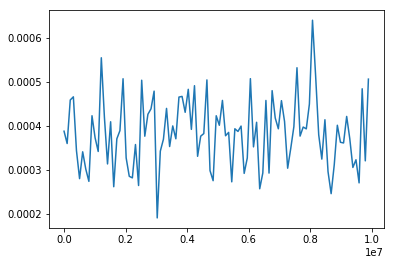

In [13]:
%%time
num_windows = 100
windows=np.linspace(0, ts.sequence_length, num=num_windows)

pop0_div = ts.diversity([ts.samples(0)], windows=windows)
plt.plot(windows[:-1], pop0_div)

Here we compute the the sequence diversity in 100 windows across the chromosome for population 0 (20,000 samples!) and plot it in **less than a second**. We've specified 100 linearly spaced windows here, but we can easily make it more or less, or use any arbitrary windows.

Conveniently, we can compute diversitys within several populations at the same time:

CPU times: user 690 ms, sys: 3.94 ms, total: 694 ms
Wall time: 693 ms


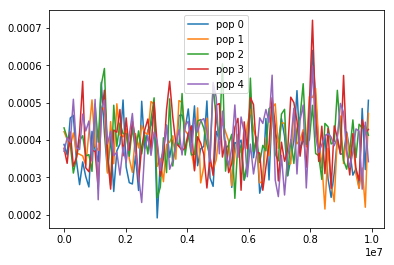

In [14]:
%%time
pop_samples = [ts.samples(j) for j in range(ts.num_populations)]
div = ts.diversity(pop_samples, windows=windows)
lines = plt.plot(windows[:-1], div)
plt.legend(lines, [f"pop {j}" for j in range(ts.num_populations)]);

Unsurprisingly, the diversity within all 5 populations is basically the same, as we can see if we look at the means  and variances along the genome:

In [39]:
np.mean(div, axis=0) 

array([0.00039273, 0.00039703, 0.00039014, 0.00039766, 0.00039708])

In [40]:
np.var(div, axis=0) 

array([5.55148332e-09, 6.38879009e-09, 5.66074924e-09, 5.09985602e-09,
       5.63772248e-09])

We can also compute divergences between populations. Since populations 3 and 4 were separated for much longer then 0 and 1, we would expect their to be higher divergences between then.

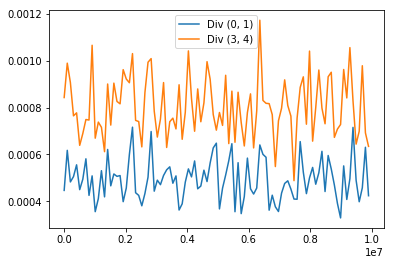

In [16]:
div_01 = ts.divergence([pop_samples[0], pop_samples[1]], windows=windows)
div_34 = ts.divergence([pop_samples[3], pop_samples[4]], windows=windows)
plt.plot(windows[:-1], div_01, label="Div (0, 1)")
plt.plot(windows[:-1], div_34, label="Div (3, 4)")
plt.legend();

We can do the same thing more conviently using the ``indexes`` argument, which allows us to choose which pairs of the sample sets we use as input.

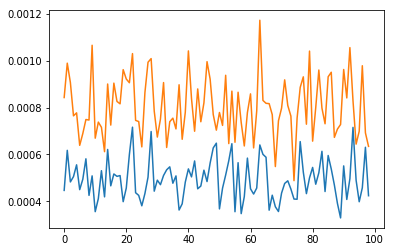

In [17]:
plt.plot(ts.divergence(pop_samples, indexes=[[0, 1], [3, 4]], windows=windows));

In [17]:
import itertools
all_pairs = list(itertools.combinations(range(ts.num_populations), 2))
all_pairs

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

In [18]:
%%time
all_divs = ts.divergence(pop_samples, indexes=all_pairs, windows=windows)

CPU times: user 233 ms, sys: 251 µs, total: 233 ms
Wall time: 232 ms


We can compute all 10 pairwise divergences in a fraction of a second! Given this output, we can plot it as before, but it's hard to pull apart 10 different lines:

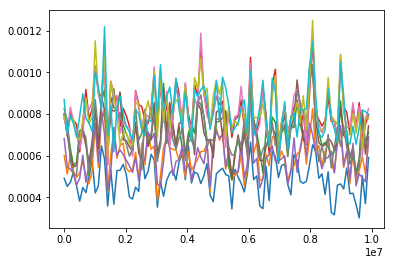

In [19]:
plt.plot(windows[:-1], all_divs);

Given the output, we can find which pair of populations has the maximum average divergence across the genome:

In [24]:
np.mean(all_divs, axis=0)

array([0.00048862, 0.00059506, 0.00071215, 0.00081502, 0.00059006,
       0.00070778, 0.00081366, 0.00070151, 0.00081572, 0.00081319])

Which pair of populations has the greatest divergence?

In [25]:
max_div_pair_index = np.argmax(np.mean(all_divs, axis=0))
all_pairs[max_div_pair_index]

(2, 4)

## Exercises

- Compute the mean pairwise divergence along the chromosome in a different way using the ``windows`` argument. Compare with values computed by numpy above.
- Compute other statistics on this dataset:
   - [Y1](https://tskit.readthedocs.io/en/latest/python-api.html#tskit.TreeSequence.Y1)
   - [Y2](https://tskit.readthedocs.io/en/latest/python-api.html#tskit.TreeSequence.Y2)
   - Patterson's [f4](https://tskit.readthedocs.io/en/latest/python-api.html#tskit.TreeSequence.f4)